In [1]:
import numpy as np

In [78]:
def phi(U,a,b,c,e,f):
    try:
        u = U[:,0]
        v = U[:,1]
    except IndexError:
        u = U[0]
        v = U[1]
    return np.exp((a*v**2 + b*u**2 - c*u*v)/(4.*a*b-c**2) + 1j*(f*v+e*u))

def psi(x,y, a, b, c, e, f):
    invSigma = np.array([[-2.0*a,-c],[-c, -2.0*b]])
    if not isinstance(x,np.ndarray):
        xx = np.array([x-e,y-f])
    else:
        xx = np.stack([x-e,y-f], axis = 1).T
    
    return np.exp(-1./2*xx.T.dot(invSigma).dot(xx))

def phi_old(u, v, l, Cx, Cy):
    return np.exp(-1.0/2.0 * (u * u + v * v) * l * l) * np.exp(1j*(Cx * u + Cy * v))

In [126]:
x = np.arange(100)
y = np.arange(100)
print('Image size x: %i\nImage size y: %i' % (x.shape[0], y.shape[0]))
u = (x-x.shape[0]/2.0)/(x.shape[0])
v = (y-y.shape[0]/2.0)/(y.shape[0])

Image size x: 100
Image size y: 100


In [127]:
factor = 1.5
s1 = 20
s2 = 20
s12 = 10

a = -1./2*s2/(s1*s2-s12**2)
b = -1./2*s1/(s1*s2-s12**2)
c = s12/(s1*s2-s12**2)
invSigma = np.array([[-2.*a,-c],[-c, -2.*b]])
print(np.linalg.inv(invSigma))

e = x.shape[0]/2
f = y.shape[0]/2
g = np.zeros((x.shape[0],y.shape[0]))

for i in range(x.shape[0]):
    for j in range(y.shape[0]):
        g[i,j] = psi(x[i],y[j],a,b,c,e,f)

[[ 20.  10.]
 [ 10.  20.]]


In [128]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

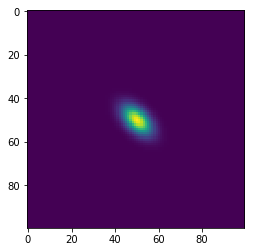

In [129]:
plt.imshow(g)

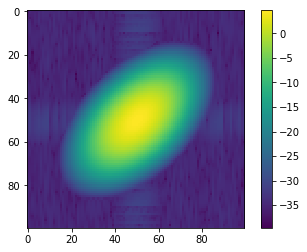

In [130]:
FTg = np.fft.fft2(g)
FTgshift = np.fft.fftshift(FTg)

plt.imshow(np.log(np.abs(FTgshift)))
plt.colorbar()

In [131]:
FTgmodel = np.zeros((u.shape[0],v.shape[0]), dtype=np.complex)
for i in range(u.shape[0]):
    for j in range(v.shape[0]):
#         print(i,u[i],j,v[j])
        U = np.array([u[i],v[j]])
        FTgmodel[i,j] = phi(U,a,b,c,e,f)
#         FTgmodel[i,j] = phi_old(u[i],v[j],np.sqrt(s1),e,f)

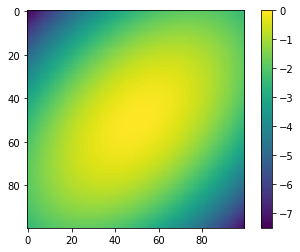

In [132]:
plt.imshow(np.log(np.abs(FTgmodel)+10e-350))
plt.colorbar()

# Inference on Edward

In [135]:
import edward as ed
import tensorflow as tf

from edward.models import Normal
from edward.models import WishartCholesky

In [136]:
def tf_phi(U,a,b,c,e,f):
    u = U[:,0]
    v = U[:,1]
    
    A = tf.exp(tf.divide(a*v**2 + b*u**2 - c*u*v, 4.*tf.multiply(a,b)-tf.multiply(c,c)))
    sinPart = tf.sin(f*v+e*u)
    cosPart = tf.cos(f*v+e*u)
    return A*cosPart, A*sinPart

def visibility_model(U,alpha,a,b,c,e,f, factor = None, IMAGE_SIZE_X = 128, IMAGE_SIZE_Y = 128):
    
    realPart, imagPart = tf_phi(U,a,b,c,e,f)
    
    return tf.stack([tf.reduce_sum(tf.multiply(alpha,realPart), axis=1), tf.reduce_sum(tf.multiply(alpha,imagPart), axis=1)], axis = 1)

In [138]:
alpha_s = tf.sqrt(tf.exp(tf.Variable(tf.random_normal([]))))
alpha_model = Normal(loc=0,scale=alpha_s*tf.ones(numberOfSamplings))

df = 5
chol_scale = tf.cholesky(np.array([[0.01,0.001],[0.001,0.01]]))

Sigma = WishartCholesky(df=df, scale=chol_scale)
s1 = Sigma[0,0]
s2 = Sigma[1,1]
s12 = Sigma[0,1]

a_model = -1./2*s2_model/(s1_model*s2_model-tf.multiply(s12_model,s12_model))
b_model = -1./2*s1_model/(s1_model*s2_model-tf.multiply(s12_model,s12_model))
c_model = s12_model/(s1_model*s2_model-tf.multiply(s12_model,s12_model))

e_model = Normal(loc=x.shape[0]/2, scale = 20)
f_model = Normal(loc=y.shape[0]/2, scale = 20)

V_model = visibility_model(U,a,b,c,e,f)
Vobs = MultivariateNormalFullCovariance(loc=V_model,
           scale=Sigma)

NameError: name 'numberOfSamplings' is not defined